# Optimal Power Profile 

Minimize 

Sum of dt

Subject to P = f(v) 

and the sum of v dt = Distance 

and Sum of P dt = E


https://www.strava.com/segments/25835330

https://www.strava.com/stream/segments/25835330?streams%5B%5D=latlng&streams%5B%5D=distance&streams%5B%5D=altitude&_=1679795135855


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import pandas as pd
import json

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [9]:
def power(v, θ):
    """Calculate power loss given ground speed velocity and angle

    Parameters
    ----------
    v : float
        Velocity (m/s)

    θ : float
        Angle (rad)

    Returns
    -------
    float
        Power loss (W)

    """
    c = 0.254
    M = 85
    g = 9.8

    return c * v**3 + M * g * v * np.sin(θ)

<IPython.core.display.Javascript object>

In [77]:
def power_to_speed(P, gradient):
    """Given a power P return the speed you'll get

    Parameters
    ----------
    P : float
        Power (W) to the pedals

    gradient : float
        Hill gradient (%)

    Returns
    -------
    float
        Part cost with breakdown of cost factors.

    """

    fun = lambda x: P - power(x, np.arctan(gradient / 100))
    sol = optimize.root(fun, 50)
    return sol.x[0]

<IPython.core.display.Javascript object>

In [78]:
KPH_PER_MPS = 3.6

power_to_speed(200, 5) * KPH_PER_MPS

15.540299173130276

<IPython.core.display.Javascript object>

Go over increments of 10 sec, integrate the velocity given a power. Integrate velocity and Power. 

In [79]:
gradients = {500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 10}
D = 4592  # meters
dt = 10  # secs
dist_traveled = 0
energy_spent = 0
total_time = 0


for i in range(999):
    P = 200
    for dist, g in gradients.items():
        if dist_traveled < dist:
            gradient = g
            break

    v = power_to_speed(P, g)
    dist_traveled += v * dt
    energy_spent += P * dt
    total_time += dt

    if dist_traveled > D:
        print("Done after", i)
        break

Done after 154


<IPython.core.display.Javascript object>

In [80]:
total_time / 60

25.833333333333332

<IPython.core.display.Javascript object>

In [81]:
dist_traveled

4615.168675894481

<IPython.core.display.Javascript object>

Add some 0 mean noise and see plot energy spent vs total time 

In [82]:
def random_power():
    return 200 + np.random.rand() * 20 - 10


def generate_power_profile(gradients):
    P = 200  # W
    power_profile = [(g, random_power()) for d, g in gradients.items()]
    diff = P - np.mean(list(dict(power_profile).values()))

    #     Set the first value to normalize the power
    power_profile[0] = power_profile[2.1] + diff * len(power_profile)
    return power_profile

<IPython.core.display.Javascript object>

In [83]:
gradients = {500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 0}
gradients

{500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 0}

<IPython.core.display.Javascript object>

In [84]:
power_profile = {g: random_power() for d, g in gradients.items()}
power_profile

{2.1: 199.07016816025003,
 5.7: 195.38938854045205,
 3.9: 208.93640221814394,
 7.2: 196.8844530608063,
 0: 198.0542917483814}

<IPython.core.display.Javascript object>

In [85]:
diff = P - np.mean(list(power_profile.values()))
diff

0.33305925439327666

<IPython.core.display.Javascript object>

In [86]:
np.mean(list(power_profile.values()))

199.66694074560672

<IPython.core.display.Javascript object>

In [87]:
x = generate_power_profile(gradients)
np.mean(list(x.values()))

TypeError: list indices must be integers or slices, not float

<IPython.core.display.Javascript object>

In [88]:
def run(gradients):
    power_profile = {g: random_power() for d, g in gradients.items()}

    D = 4622  # meters
    dt = 10  # secs
    dist_traveled = 0
    energy_spent = 0
    total_time = 0
    power_profile_list = []
    for i in range(999999):
        #         P = 200 + np.random.rand() * 10 - 5
        for dist, g in gradients.items():
            if dist_traveled < dist:
                gradient = g
                break
        P = power_profile[gradient]
        power_profile_list.append(P)
        v = power_to_speed(P, g)
        dist_traveled += v * dt
        energy_spent += P * dt
        total_time += dt

        if dist_traveled > D:
            break
    return {
        "dist_traveled": dist_traveled,
        "total_time": total_time,
        "energy_spent": energy_spent,
        "power_profile": power_profile,
    }

<IPython.core.display.Javascript object>

In [89]:
data = [run(gradients=gradients) for i in range(100)]

<IPython.core.display.Javascript object>

In [90]:
df = pd.DataFrame(data)
df

,dist_traveled,total_time,energy_spent,power_profile
0,4630.259121,730,148731.650994,"{2.1: 199.036189576056, 5.7: 198.9456005359422..."
1,4679.179419,750,147775.176469,"{2.1: 198.8270640451294, 5.7: 203.196218778505..."
2,4632.002971,720,148542.993547,"{2.1: 198.366096329589, 5.7: 206.6235032745213..."
3,4689.331091,740,148323.734007,"{2.1: 209.86917659938572, 5.7: 194.02228436425..."
4,4663.979716,740,146496.744735,"{2.1: 205.66053476902866, 5.7: 203.68603376227..."
...,...,...,...,...
95,4683.585179,740,147945.006001,"{2.1: 205.45827250337038, 5.7: 195.23888830622..."
96,4624.518520,730,148236.694082,"{2.1: 198.9333163199155, 5.7: 197.415083223921..."
97,4696.968613,740,148643.682090,"{2.1: 193.79545124749194, 5.7: 192.00247876801..."
98,4668.897222,740,147062.823235,"{2.1: 209.8817876803339, 5.7: 206.654048119348..."


<IPython.core.display.Javascript object>

In [91]:
df.describe()

,dist_traveled,total_time,energy_spent
count,100.000000,100.000000,100.000000
mean,4668.968240,740.700000,147942.798124
std,25.508570,7.946157,1264.361832
min,4624.403453,720.000000,145427.357131
25%,4649.725077,740.000000,146953.294667
50%,4670.237206,740.000000,148112.167874
75%,4689.258990,750.000000,149035.001142
max,4714.517532,760.000000,150472.305308


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='energy_spent', ylabel='total_time'>

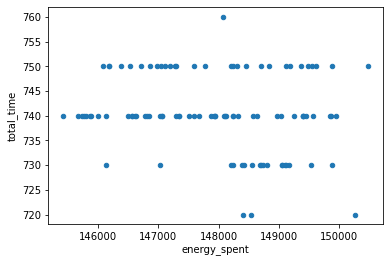

<IPython.core.display.Javascript object>

In [92]:
df.plot.scatter(x="energy_spent", y="total_time")

<AxesSubplot:>

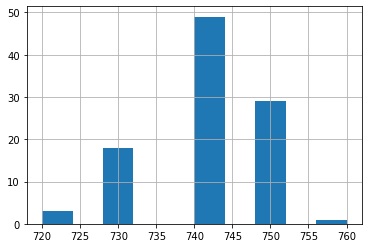

<IPython.core.display.Javascript object>

In [93]:
df.total_time.hist()

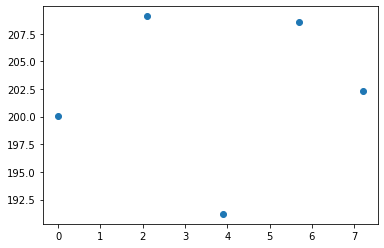

<IPython.core.display.Javascript object>

In [94]:
sel = df[df.energy_spent < df.energy_spent.mean()]

p = sel[sel.total_time == sel.total_time.min()].head(1).power_profile.values[0]

plt.scatter(p.keys(), p.values())

In [95]:
flagstaff = pd.read_json("strava/flagstaff.json")
flagstaff

,latlng,distance,altitude
0,"[39.99931, -105.290627]",0.0,1744.6
1,"[39.999435, -105.290726]",16.6,1746.1
2,"[39.999485, -105.290741]",22.2,1746.4
3,"[39.999588, -105.290733]",34.0,1746.6
4,"[40.000076, -105.290573]",89.8,1747.8
...,...,...,...
165,"[39.997696, -105.308296]",4554.8,2053.0
166,"[39.99754, -105.308517]",4580.7,2053.4
167,"[39.997337, -105.308754]",4610.9,2053.4
168,"[39.997311, -105.308792]",4615.0,2052.3


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='distance'>

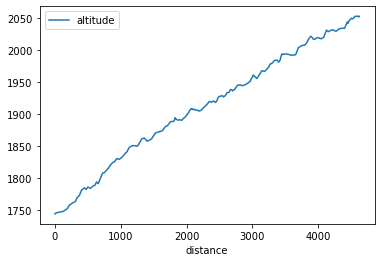

<IPython.core.display.Javascript object>

In [96]:
flagstaff.plot(x="distance", y="altitude")

In [97]:
(flagstaff.altitude.diff() / flagstaff.distance.diff()).describe()

count    169.000000
mean       0.066405
std        0.126516
min       -0.468085
25%        0.000000
50%        0.055785
75%        0.128889
max        0.436364
dtype: float64

<IPython.core.display.Javascript object>

In [98]:
sel = flagstaff.rolling(window=3, min_periods=1, center=True).mean().diff()
flagstaff["gradient"] = (sel.altitude / sel.distance) * 100
flagstaff.gradient = flagstaff.gradient.fillna(method="bfill")
flagstaff.gradient = flagstaff.gradient.round(decimals=1)

<IPython.core.display.Javascript object>

In [99]:
flagstaff

,latlng,distance,altitude,gradient
0,"[39.99931, -105.290627]",0.0,1744.6,7.6
1,"[39.999435, -105.290726]",16.6,1746.1,7.6
2,"[39.999485, -105.290741]",22.2,1746.4,5.9
3,"[39.999588, -105.290733]",34.0,1746.6,2.3
4,"[40.000076, -105.290573]",89.8,1747.8,2.1
...,...,...,...,...
165,"[39.997696, -105.308296]",4554.8,2053.0,4.2
166,"[39.99754, -105.308517]",4580.7,2053.4,4.7
167,"[39.997337, -105.308754]",4610.9,2053.4,-1.2
168,"[39.997311, -105.308792]",4615.0,2052.3,-0.7


<IPython.core.display.Javascript object>

{500: 2.1, 1000: 5.7, 1500: 3.9, 2000: 7.2, 99999: 0}

<IPython.core.display.Javascript object>

In [102]:
flagstaff_gradients = {r.distance: r.gradient for r in flagstaff.itertuples()}
flagstaff_gradients

{0.0: 7.6,
 16.600000000000364: 7.6,
 22.200000000000728: 5.9,
 34.0: 2.3,
 89.80000000000109: 2.1,
 129.20000000000073: 3.6,
 163.10000000000036: 4.9,
 185.60000000000036: 10.7,
 219.8000000000011: 10.5,
 251.0: 10.7,
 278.39999999999964: 6.0,
 309.8000000000011: 10.8,
 336.8000000000011: 11.9,
 372.3000000000011: 19.0,
 405.60000000000036: 14.0,
 447.5: 9.2,
 473.39999999999964: 4.9,
 500.89999999999964: -0.9,
 540.6000000000004: 5.1,
 574.8000000000011: 2.6,
 607.8999999999996: 10.9,
 632.7000000000007: 4.6,
 657.8000000000011: 12.5,
 688.1000000000004: 14.5,
 714.5: 24.2,
 727.1000000000004: 15.5,
 747.6000000000004: 9.1,
 771.6000000000004: 8.6,
 812.0: 13.0,
 844.3999999999996: 12.5,
 876.2000000000007: 11.0,
 903.6000000000004: 10.3,
 940.1000000000004: 5.3,
 975.0: 5.6,
 996.2000000000007: 2.9,
 1020.8000000000011: 9.4,
 1044.3999999999996: 11.0,
 1068.800000000001: 11.0,
 1098.7000000000007: 12.5,
 1102.800000000001: 15.0,
 1135.6000000000004: 10.9,
 1185.300000000001: 5.9,
 1

<IPython.core.display.Javascript object>

# Run on real data 

In [46]:
# run(gradients=flagstaff_gradients)

<IPython.core.display.Javascript object>

In [105]:
data = [run(gradients=flagstaff_gradients) for i in range(100)]

df = pd.DataFrame(data)
df.describe()

,dist_traveled,total_time,energy_spent
count,100.000000,100.000000,100.000000
mean,4699.657540,1268.000000,253725.511417
std,45.631813,25.105837,4782.315162
min,4622.140874,1200.000000,241498.910175
25%,4693.557662,1250.000000,250572.417793
50%,4697.910347,1270.000000,253460.672747
75%,4706.765609,1290.000000,257474.314503
max,4804.161273,1330.000000,265541.543444


<IPython.core.display.Javascript object>

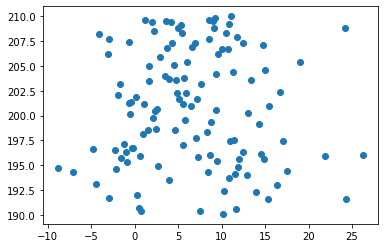

<IPython.core.display.Javascript object>

In [106]:
sel = df[df.energy_spent < df.energy_spent.mean()]

p = sel[sel.total_time == sel.total_time.min()].head(1).power_profile.values[0]

plt.scatter(p.keys(), p.values())

# Set up an optimization problem 

Alow input vector of length 170. Sum up the time taken.

In [144]:
from scipy.optimize import LinearConstraint


# Sum of power is capped

linear_constraint = LinearConstraint([[1] * 170], lb=[1], ub=[200 * 170])

<IPython.core.display.Javascript object>

In [163]:
def run(gradients, power_profile):

    D = 4622  # meters
    dt = 10  # secs
    dist_traveled = 0
    energy_spent = 0
    total_time = 0
    power_profile_list = []
    for i in range(9999):
        #         P = 200 + np.random.rand() * 10 - 5
        for dist, g in gradients.items():
            if dist_traveled < dist:
                gradient = g
                break
        P = power_profile[gradient]
        power_profile_list.append(P)
        v = power_to_speed(P, g)
        dist_traveled += v * dt
        energy_spent += P * dt
        total_time += dt
        #         print(f"P={P}, g={g}, D={D}, v={v}")
        if dist_traveled > D:
            break
    return {
        "dist_traveled": dist_traveled,
        "total_time": total_time,
        "energy_spent": energy_spent,
        "power_profile": power_profile,
    }

<IPython.core.display.Javascript object>

In [164]:
def minimize_me(powers):
    """Calculate power loss given ground speed velocity and angle

    Parameters
    ----------
    powers : list
        list of powers

    Returns
    -------
    float
        Total time (s)

    """
    power_profile = dict(zip(flagstaff_gradients.values(), powers))
    result = run(gradients=flagstaff_gradients, power_profile=power_profile)

    return result["total_time"]

<IPython.core.display.Javascript object>

In [169]:
minimize_me([200] * 170)

1320

<IPython.core.display.Javascript object>

In [174]:
minimize_me([299] * 170)

890

<IPython.core.display.Javascript object>

In [177]:
optimize.minimize(
    fun=minimize_me, x0=np.array([177] + [199] * 169), constraints=linear_constraint
)

     fun: 1240.0
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 171
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([177., 199., 199., 199., 199., 199., 199., 199., 199., 199., 199.,
       199., 199., 199., 

<IPython.core.display.Javascript object>